In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
import re
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

In [ ]:
MAX_LENGTH = 250
LR = 0.000040
AUTO = tf.data.experimental.AUTOTUNE
lr= 2e-5
wd=0.01

In [ ]:
#ref:https://www.kaggle.com/bharadwajvedula/clr-lb-0-475-lazy-way-to-get-good-score

In [ ]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

# removing unused columns
train_data.drop(['url_legal', 'license','standard_error'], axis=1, inplace=True)
test_data.drop(['url_legal', 'license'], axis=1, inplace=True)

from sklearn.model_selection import train_test_split
X=train_data['excerpt']
y=train_data['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=20)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.15,random_state=20)
x_td=test_data['excerpt']

In [ ]:
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):
    input_ids = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,max_length=max_length,padding='max_length',truncation=True)
        input_ids.extend(inputs['input_ids'])
    return tf.convert_to_tensor(input_ids)

In [ ]:
from transformers import RobertaConfig, RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('../input/huggingface-roberta-variants/roberta-base/roberta-base')
# RoBerta Model:
#config = RobertaConfig(attention_probs_dropout_prob=0.2)
RoBerta = TFRobertaModel.from_pretrained('../input/huggingface-roberta-variants/roberta-base/roberta-base')

Some layers from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
def build_model(transformer, max_length=MAX_LENGTH):
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),name='input_ids',dtype='int32')
    last_hidden_state = transformer(input_ids_layer)[0]
    cls_token = last_hidden_state[:, 0, :]
    output = tf.keras.layers.Dense(1,activation='linear',dtype = 'float32',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(cls_token)
    model = tf.keras.Model(input_ids_layer, output)
    model.compile(tf.keras.optimizers.Adam(lr = LR),  loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
def train_models_1():
    import numpy as np
    import random
    from sklearn.model_selection import KFold
    from tensorflow.keras import backend as K
    models_list=[]
    fold=0
    seed=123
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    kf=KFold(n_splits=3, random_state=seed, shuffle=True)

    for train_index, test_index in kf.split(X):
        K.clear_session()
        fold=fold+1
        print('fold:',fold)
        x_train, x_cv = X[train_index], X[test_index]
        y_train, y_cv = y[train_index], y[test_index] 
        x_train_ids = batch_encode(tokenizer, x_train.tolist())
        x_cv_ids = batch_encode(tokenizer, x_cv.tolist()) 

        model=build_model(RoBerta,250)
        EPOCHS = 1
        BATCH_SIZE = 24
        NUM_STEPS = len(x_train.index) // (BATCH_SIZE*16)

        # Train the model
        from keras.callbacks import EarlyStopping
        early_stop_1=EarlyStopping(monitor='val_root_mean_squared_error',patience=7,restore_best_weights=True,mode='min')
        checkpoint = tf.keras.callbacks.ModelCheckpoint('./Roberta_Base_'+str(fold)+'.h5', 
                                                monitor = 'val_root_mean_squared_error', 
                                                verbose = 2, 
                                                save_best_only = True,
                                                save_weights_only = True, 
                                                mode = 'min')
        model.fit(
        x = x_train_ids,
        y = y_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        steps_per_epoch = NUM_STEPS,
        validation_data = (x_cv_ids, y_cv),
        verbose=1,callbacks=[checkpoint,early_stop_1]
        )
        models_list.append(model)
    for i in range(len(models_list)):
        models_list[i].save_weights('./reberta_model'+str(i)+'.h5')
    return models_list


In [ ]:
models_list=train_models_1()

In [ ]:
max_len=250
#print('tokenization')
train_embeddings = tokenizer(X.to_list(), truncation = True , padding = 'max_length' , max_length=max_len)
test_embeddings = tokenizer(x_td.to_list() , truncation = True , padding = 'max_length' , max_length = max_len)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
@tf.function

def map_function(encodings):
    input_ids = encodings['input_ids']
    
    return {'input_word_ids': input_ids}

print("generating train and test")    
train = tf.data.Dataset.from_tensor_slices((train_embeddings))
train = (
            train
            .map(map_function, num_parallel_calls=AUTOTUNE)
            .batch(16)
            .prefetch(AUTOTUNE)
        )


test = tf.data.Dataset.from_tensor_slices((test_embeddings))
test = (
        test
        .map(map_function, num_parallel_calls = AUTOTUNE)
        .batch(16)
        .prefetch(AUTOTUNE)
    )

generating train and test


In [ ]:
def build_roberta_base_model(max_length=max_len):
    transformer = TFRobertaModel.from_pretrained("../input/huggingface-roberta-variants/roberta-base/roberta-base")
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),name='input_word_ids',dtype=tf.int32)
    last_hidden_state = transformer(input_ids_layer)[0]
    cls_token = last_hidden_state[:, 0, :]
    output = tf.keras.layers.Dense(1,activation='linear',dtype = 'float32')(cls_token)
    model = tf.keras.Model(input_ids_layer, output)
    #model.compile(tf.keras.optimizers.Adam(lr = LR),  loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
def get_preds(path,train,test):
    print("loading weights")
    ragnar_model=build_roberta_base_model(250)
    ragnar_model.load_weights(path)
    x= ragnar_model.layers[-3].output
    model = Model(inputs = ragnar_model.inputs , outputs = x)
    print("Extracting Features from train data")
    train_features = model.predict( train , verbose =1)
    train_features = train_features.last_hidden_state
    train_features = train_features[: , 0 , :]
    print("Extracting Features from train data")
    test_features = model.predict( test , verbose =1)
    test_features = test_features.last_hidden_state
    test_features = test_features[: , 0 , :]
    
    return np.array(train_features , dtype= np.float16) , np.array(test_features , dtype= np.float16) 

In [ ]:
x_td_ids = batch_encode(tokenizer, x_td.tolist())
#models_list[0].predict(x_td_ids)

In [ ]:
#model_rb=build_model(RoBerta,250)
#model_rb.load_weights('./reberta_model0.h5')
#model1.compile(tf.keras.optimizers.Adam(lr = LR),  loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])
#model_rb.predict(x_td_ids)

In [ ]:
#model weight paths
paths=["../input/roberta-v1/Roberta_Base_1.h5",
       "../input/roberta-v1/Roberta_Base_2.h5",
       "../input/roberta-v1/Roberta_Base_3.h5",
       "../input/roberta-v1/Roberta_Base_4.h5",
       "../input/roberta-v1/Roberta_Base_5.h5"
      ]

In [ ]:
train_embeddings1 , test_embeddings1 = get_preds(paths[0] , train , test)
train_embeddings2 , test_embeddings2 = get_preds(paths[1] , train , test)
train_embeddings3 , test_embeddings3 = get_preds(paths[2] , train , test)
train_embeddings4 , test_embeddings4 = get_preds(paths[3] , train , test)
train_embeddings5 , test_embeddings5 = get_preds(paths[4] , train , test)

loading weights


Some layers from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Extracting Features from train data
178/178 [==============================] - 34s 177ms/step
Extracting Features from train data
1/1 [==============================] - 0s 156ms/step
loading weights


Some layers from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Extracting Features from train data
178/178 [==============================] - 35s 181ms/step
Extracting Features from train data
1/1 [==============================] - 0s 167ms/step
loading weights


Some layers from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Extracting Features from train data
178/178 [==============================] - 35s 181ms/step
Extracting Features from train data
1/1 [==============================] - 0s 176ms/step
loading weights


Some layers from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Extracting Features from train data
178/178 [==============================] - 34s 177ms/step
Extracting Features from train data
1/1 [==============================] - 0s 105ms/step
loading weights


Some layers from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Extracting Features from train data
178/178 [==============================] - 34s 177ms/step
Extracting Features from train data
1/1 [==============================] - 0s 138ms/step


In [ ]:
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
SEED=123
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse

In [ ]:
def get_preds_2(train_embeddings , test_embeddings):
    
    scores=[]
    kfold = KFold(n_splits=5, shuffle= True , random_state= SEED)
    iteration=1
    preds = np.zeros((test_embeddings.shape[0]))
    for train_idx, test_idx in kfold.split(train_embeddings,y):
        print(f'running iteration {iteration}')
        X_train = train_embeddings[train_idx]
        X_test = train_embeddings[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]

        #regression_model = Ridge()
        from sklearn.svm import SVR
        from sklearn.ensemble import RandomForestRegressor
        from catboost import CatBoostRegressor
        regression_model = SVR(C=25,kernel='rbf')
        regression_model.fit(X_train,y_train)
        y_pred = regression_model.predict(X_test)

        score = np.sqrt(mse(y_pred,y_test))
        scores.append(score)
        print(f'Fold {iteration} , rmse score: {score}')
        y_preds = regression_model.predict(test_embeddings)
        y_preds=y_preds.reshape(-1)
        preds+=y_preds  
        iteration += 1

    print(f"the average rmse is {np.mean(scores)}")
    return np.array(preds)/5  

In [ ]:
print("***********predicting***********")
preds1 = get_preds_2(train_embeddings1,test_embeddings1)
print("***********predicting***********")
preds2 = get_preds_2(train_embeddings2,test_embeddings2)
print("***********predicting***********")
preds3 = get_preds_2(train_embeddings3,test_embeddings3)
print("***********predicting***********")
preds4 = get_preds_2(train_embeddings4,test_embeddings4)
print("***********predicting***********")
preds5 = get_preds_2(train_embeddings5,test_embeddings5)

***********predicting***********
running iteration 1
Fold 1 , rmse score: 0.5006730648089416
running iteration 2
Fold 2 , rmse score: 0.3734255933093291
running iteration 3
Fold 3 , rmse score: 0.38327015220420174
running iteration 4
Fold 4 , rmse score: 0.38920561412518434
running iteration 5
Fold 5 , rmse score: 0.3763602497765708
the average rmse is 0.40458693484484554
***********predicting***********
running iteration 1
Fold 1 , rmse score: 0.4569465281444052
running iteration 2
Fold 2 , rmse score: 0.40446301496210263
running iteration 3
Fold 3 , rmse score: 0.37185419444438694
running iteration 4
Fold 4 , rmse score: 0.3600748627763718
running iteration 5
Fold 5 , rmse score: 0.3614864472572959
the average rmse is 0.3909650095169125
***********predicting***********
running iteration 1
Fold 1 , rmse score: 0.4429892391721204
running iteration 2
Fold 2 , rmse score: 0.4033752355404781
running iteration 3
Fold 3 , rmse score: 0.3910750311099624
running iteration 4
Fold 4 , rmse scor

In [ ]:
preds=(preds1+preds2+preds3+preds4+preds5)/5
preds = preds.tolist()

In [ ]:
sub=pd.DataFrame({'id':test_data['id'],'target':preds})
sub.to_csv('submission.csv',index=False)
sub.head()

,id,target
0,c0f722661,-0.807744
1,f0953f0a5,-0.454447
2,0df072751,-0.497256
3,04caf4e0c,-2.716378
4,0e63f8bea,-1.946026


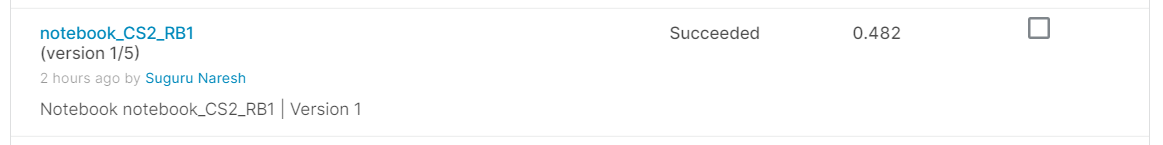